In [1]:
!pip install timm

     |████████████████████████████████| 431 kB 7.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/braian/anaconda3/envs/nn_project/bin/python -m pip install --upgrade pip' command.


In [53]:
import timm
from timm.data import create_dataset
import torch
import torchvision
import torchvision.transforms as transforms
import os
import shutil
from time import sleep
import copy

from urllib.request import urlretrieve
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'crossvit_9_240',
 'crossv

In [21]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

In [22]:
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,),

## Datasets

There are a couple options for datasets. The main requirement is to have a ground truth segmentation mask, or being easy to segment the image into FG/BG easily with a pre-trained segmentation model

1. IN9: 9 high level class derived from imagenet with segmentation mask. From ["Noise or Signal: The Role of Image Backgrounds in Object Recognition"](https://arxiv.org/abs/2006.09994)
2. CIFAR10: 32x32 images from 10 classes, **no segmentation mask** provided.
3. COCO: Dataset for segmentation. TODO: is it worth using it since it has multiple objects segmented and not only FG/BG.

In [16]:
os.makedirs("imagenet", exist_ok=True)
if not os.path.isfile("imagenet/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "imagenet/ilsvrc2012_wordnet_lemmas.txt")
imagenet_labels = dict(enumerate(open('imagenet/ilsvrc2012_wordnet_lemmas.txt')))

In [69]:
# download and extract IN9 dataset described here https://arxiv.org/abs/2006.09994
os.makedirs("IN9", exist_ok=True)
if not os.path.isfile("IN9/backgrounds_challenge_data.tar.gz"):
    urlretrieve("https://github.com/MadryLab/backgrounds_challenge/releases/download/data/backgrounds_challenge_data.tar.gz", "IN9/backgrounds_challenge_data.tar.gz")

import tarfile
my_tar = tarfile.open('IN9/backgrounds_challenge_data.tar.gz')
my_tar.extractall('IN9/') 
my_tar.close()    

In [26]:
# in9_ds = create_dataset(name='', root='IN9/bg_challenge/backgrounds_challenge_data.tar.gz')

In [6]:
segmentation_sample = np.load("IN9/bg_challenge/fg_mask/val/00_dog/n02085620_16757.npy")
image_sample = Image.open("IN9/bg_challenge/original/val/00_dog/n02085620_16757.JPEG").convert("RGB")

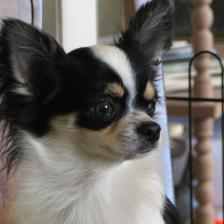

In [7]:
image_sample

In [8]:
np_image_sample = np.array(image_sample)
np_image_sample[~segmentation_sample] = 0.0

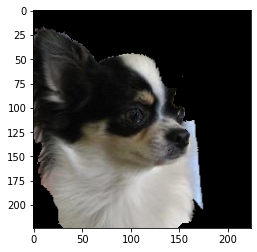

In [9]:
plt.imshow(np_image_sample)

In [24]:
ds = create_dataset('torch/cifar10', 'cifar10', download=True, split='test')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10


airplane


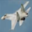

In [58]:
print(ds.classes[ds[10][1]])
ds[10][0]

In [10]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch_size = 4

# testset = torchvision.datasets.CIFAR10(root='data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
input_image = transform(image_sample)
input_image.unsqueeze(0).shape


torch.Size([1, 3, 224, 224])

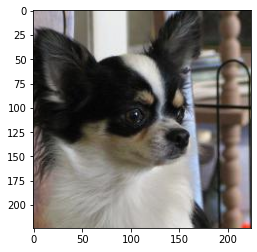

NameError: name 'batch_size' is not defined

In [13]:


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# # get some random training images
# dataiter = iter(testloader)
# images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(input_image))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [23]:
output = model(input_image.unsqueeze(0))
output.shape

torch.Size([1, 1000])

In [24]:
imagenet_labels[np.argmax(output.detach().numpy())]

'Chihuahua\n'

In [26]:
feat = model.forward_features(input_image.unsqueeze(0))

In [27]:
feat.shape

torch.Size([1, 768])

In [28]:
head = model.get_classifier()

In [29]:
head

Linear(in_features=768, out_features=1000, bias=True)

In [32]:
block = model.blocks[0]

In [37]:
block

Block(
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU()
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
)

In [44]:
np.reshape(np.zeros((1,768)), (-1, 2)).shape

(384, 2)

In [45]:
np.sqrt(768)

27.712812921102035

In [46]:
224*224

50176

## Conclusion 
Too dificult to adapt timm to get intermediate attention maps.

Will use solution from previous work from CNS

## Datasets

### SUN397 for backgrounds

In [5]:
torchvision.__version__

'0.11.2+cu102'

In [6]:
!pip install torchvision==0.12

     |████████████████████████████████| 21.0 MB 10.2 MB/s eta 0:00:01
     |████████████████████████████████| 750.6 MB 94 kB/s s eta 0:00:01    |▉                               | 20.2 MB 12.9 MB/s eta 0:00:57     |█████████▉                      | 229.7 MB 10.6 MB/s eta 0:00:50     |███████████▏                    | 261.3 MB 10.4 MB/s eta 0:00:48     |█████████████                   | 303.1 MB 4.5 MB/s eta 0:01:40     |█████████████▏                  | 308.6 MB 11.2 MB/s eta 0:00:40     |█████████████▏                  | 309.8 MB 11.2 MB/s eta 0:00:40     |███████████████                 | 349.7 MB 12.3 MB/s eta 0:00:33     |███████████████▉                | 371.5 MB 4.4 MB/s eta 0:01:27     |██████████████████              | 420.0 MB 12.0 MB/s eta 0:00:28     |██████████████████              | 421.8 MB 12.0 MB/s eta 0:00:28     |██████████████████▎             | 429.7 MB 53.6 MB/s eta 0:00:06     |█████████████████████           | 494.1 MB 12.4 MB/s eta 0:00:21     |██████████████████

In [2]:
torchvision.__version__

'0.12.0+cu102'

In [1]:
from torchvision.datasets.sun397 import SUN397

In [2]:
sun_ds = SUN397(root='data')

In [ ]:
#classes: grass, sky, tree, water, rocks
# manually filter by inspecting images here https://vision.princeton.edu/projects/2010/SUN/explore/

In [8]:
sun_ds.classes

['abbey',
 'airplane_cabin',
 'airport_terminal',
 'alley',
 'amphitheater',
 'amusement_arcade',
 'amusement_park',
 'anechoic_chamber',
 'apartment_building/outdoor',
 'apse/indoor',
 'aquarium',
 'aqueduct',
 'arch',
 'archive',
 'arrival_gate/outdoor',
 'art_gallery',
 'art_school',
 'art_studio',
 'assembly_line',
 'athletic_field/outdoor',
 'atrium/public',
 'attic',
 'auditorium',
 'auto_factory',
 'badlands',
 'badminton_court/indoor',
 'baggage_claim',
 'bakery/shop',
 'balcony/exterior',
 'balcony/interior',
 'ball_pit',
 'ballroom',
 'bamboo_forest',
 'banquet_hall',
 'bar',
 'barn',
 'barndoor',
 'baseball_field',
 'basement',
 'basilica',
 'basketball_court/outdoor',
 'bathroom',
 'batters_box',
 'bayou',
 'bazaar/indoor',
 'bazaar/outdoor',
 'beach',
 'beauty_salon',
 'bedroom',
 'berth',
 'biology_laboratory',
 'bistro/indoor',
 'boardwalk',
 'boat_deck',
 'boathouse',
 'bookstore',
 'booth/indoor',
 'botanical_garden',
 'bow_window/indoor',
 'bow_window/outdoor',
 'bowl

In [14]:
cls_filter = {'water': ['pond', 'ocean'],
              'grass': ['pasture'],
              'sky': ["sky"],
              'tree': ["forest/needleleaf", "forest/broadleaf"],
              'rock': ["cliff"],
             }
cls_filter

{'water': ['pond', 'ocean'],
 'grass': ['pasture'],
 'sky': ['sky'],
 'tree': ['forest/needleleaf', 'forest/broadleaf'],
 'rock': ['cliff']}

In [68]:
list(cls_filter.keys())

['water', 'grass', 'sky', 'tree', 'rock']

In [25]:


BASE_SUN_DIR = "data/SUN397/"
SUN5_DIR = "data/SUN5/"
os.makedirs(SUN5_DIR, exist_ok=True)
for cls_name, sun_classes in cls_filter.items():
    if not os.path.exists(os.path.join(SUN5_DIR, cls_name)):
        os.makedirs(os.path.join(SUN5_DIR, cls_name))
        sleep(1)
        for sun_cls in sun_classes:
            dst = os.path.join(SUN5_DIR, cls_name)
            src_dir = os.path.join(BASE_SUN_DIR, f"{sun_cls[0]}/{sun_cls}")
            files = os.listdir(src_dir)
            for file in files:
                src = os.path.join(BASE_SUN_DIR, f"{sun_cls[0]}/{sun_cls}/{file}")
                shutil.copy(src, dst)
    

In [36]:
def get_random_bg(class_name):
    bg_files = os.listdir(os.path.join(SUN5_DIR, class_name))    
    return os.path.join(SUN5_DIR, class_name, np.random.choice(bg_files))

In [37]:
get_random_bg('water')

'data/SUN5/water/sun_asocvzfciqnjjzoa.jpg'

### Merge SUN data with IN9 dataset

Each one of the 9 classes has 450 images with segmentation.

Create a new dataset with each one of the images in all the 5 different BG

Start with only 100 images per class (100 x 5)

In [38]:
IN9_BASE_IMG_DIR = "IN9/bg_challenge/original/val/"
IN9_BASE_MASK_DIR = "IN9/bg_challenge/fg_mask/val/"
in9_classes = os.listdir(IN9_BASE_IMG_DIR)
in9_classes

['00_dog',
 '01_bird',
 '02_wheeled vehicle',
 '03_reptile',
 '04_carnivore',
 '05_insect',
 '06_musical instrument',
 '07_primate',
 '08_fish']

In [89]:
# LIMIT = 300
BG_IN9_BASE_DIR = "data/IN9_SUN_BG"

#create new dataset folder structure
if not os.path.exists(BG_IN9_BASE_DIR):
    os.makedirs(BG_IN9_BASE_DIR, exist_ok=True)
    for in9_cls in in9_classes:
        for sun_cls in sun_classes:        
            new_class_name = f"{in9_cls}_{sun_cls}"
            os.makedirs(os.path.join(BG_IN9_BASE_DIR, new_class_name))


sun_classes = list(cls_filter.keys())
for in9_cls in in9_classes:
    in9_filenames = os.listdir(os.path.join(IN9_BASE_IMG_DIR, in9_cls))
    in9_filenames = in9_filenames
    for in9_file in in9_filenames:
        in9_img = Image.open(os.path.join(IN9_BASE_IMG_DIR, in9_cls, in9_file)).convert("RGB")
        mask_file = in9_file[:-4] + "npy"
        mask = np.load(os.path.join(IN9_BASE_MASK_DIR, in9_cls, mask_file))
        in9_img = np.array(in9_img)
        for sun_cls in sun_classes:
            new_class_name = f"{in9_cls}_{sun_cls}"
#             if not os.path.exists(os.path.join(BG_IN9_BASE_DIR, new_class_name, in9_file)):
            bg_file = get_random_bg(sun_cls)
            bg_img = Image.open(bg_file).convert('RGB').resize((224, 224))
            bg_img = np.array(bg_img)
            aug_image = copy.deepcopy(in9_img)
            aug_image[~mask] = bg_img[~mask]            
            Image.fromarray(aug_image).save(os.path.join(BG_IN9_BASE_DIR, new_class_name, in9_file))
            break
        break
    break

(-0.5, 223.5, 223.5, -0.5)

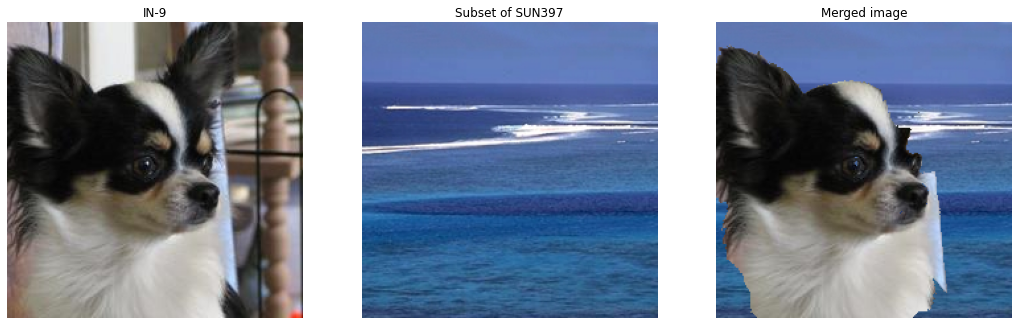

In [92]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))
axs[0].imshow(in9_img)
axs[0].set_title("IN-9")
axs[0].axis("off")
axs[1].imshow(bg_img)
axs[1].set_title("Subset of SUN397")
axs[1].axis("off")
axs[2].imshow(aug_image)
axs[2].set_title("Merged image")
axs[2].axis("off")
